<a href="https://colab.research.google.com/github/1234Godwin/Alzheimer-Disease-Classification/blob/main/Alzheimer_Disease_Classification_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

In [ ]:
import os
from google.colab import userdata

# Retrieve Kaggle credentials from Colab Secrets
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# Kaggle CLI will now use these environment variables for authentication

# Create .kaggle directory if it doesn't exist (still good practice for Kaggle CLI)
!mkdir -p ~/.kaggle


In [ ]:
# Download the dataset
!kaggle datasets download -d aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented

Dataset URL: https://www.kaggle.com/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented
License(s): apache-2.0
alzheimers-multiclass-dataset-equal-and-augmented.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the dataset
import zipfile

zip_file_name = 'alzheimers-multiclass-dataset-equal-and-augmented.zip' # Make sure this matches the downloaded file name
extraction_dir = './alzheimers_multiclass_dataset'

if os.path.exists(zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir) # Extract to a new directory
    print(f"'{zip_file_name}' extracted to '{extraction_dir}'.")
else:
    print(f"Error: '{zip_file_name}' not found. Please check the dataset download step.")

'alzheimers-multiclass-dataset-equal-and-augmented.zip' extracted to './alzheimers_multiclass_dataset'.


In [ ]:
# List the contents of the extracted directory
!ls -R ./alzheimers_mri_dataset

ls: cannot access './alzheimers_mri_dataset': No such file or directory


In [ ]:
base_dir = './alzheimers_multiclass_dataset/combined_images' # Point to the directory containing images

if os.path.exists(base_dir):
    print(f"Contents of '{base_dir}':")
    for item in os.listdir(base_dir):
        print(item)

    # Optionally, if the output is too long, we can just print the first few levels
    # import glob
    # print("\nFirst few files/folders:")
    # for path in sorted(glob.glob(base_dir + '/**/*', recursive=True))[:20]:
    #     print(path)

else:
    print(f"Error: Image directory '{base_dir}' not found.")

Contents of './alzheimers_multiclass_dataset/combined_images':
VeryMildDemented
MildDemented
ModerateDemented
NonDemented


## Analysis of Class Distribution

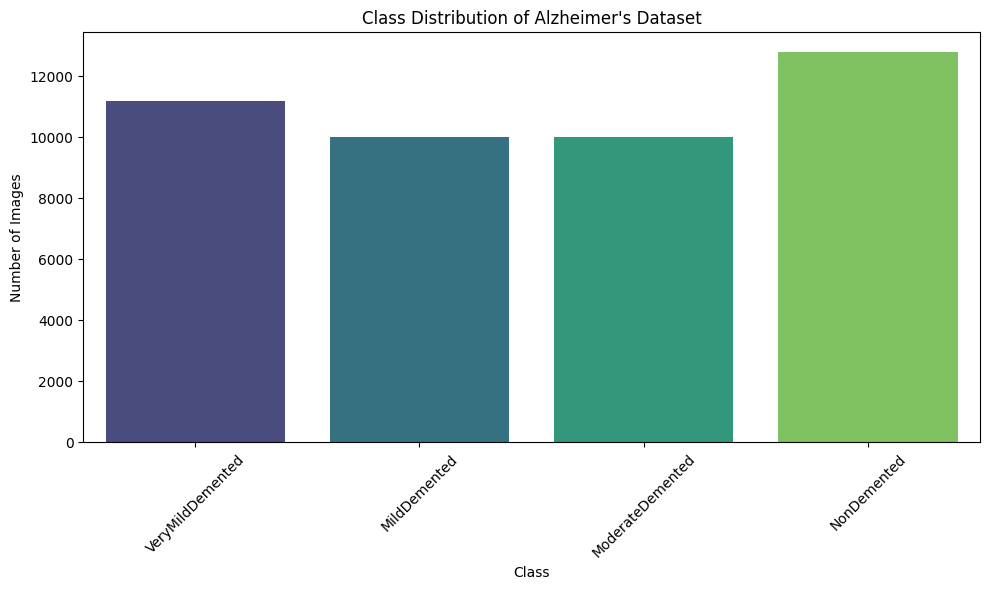

Number of images per class:
{'VeryMildDemented': 11200, 'MildDemented': 10000, 'ModerateDemented': 10000, 'NonDemented': 12800}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize an empty dictionary to store class counts
class_counts = {}

# 2. Iterate through each subdirectory within the base_dir
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        # 3. Count the number of files (images) in each class directory
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# 4. Create a Pandas Series from the class_counts dictionary
class_distribution = pd.Series(class_counts)

# 6. Generate a bar plot to visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values,
          hue=class_distribution.index, legend=False,palette='viridis')

# 7. Add a title, and label axes
plt.title("Class Distribution of Alzheimer's Dataset")
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()

# 8. Display the plot
plt.show()

# 9. Print the class_counts dictionary
print("Number of images per class:")
print(class_counts)

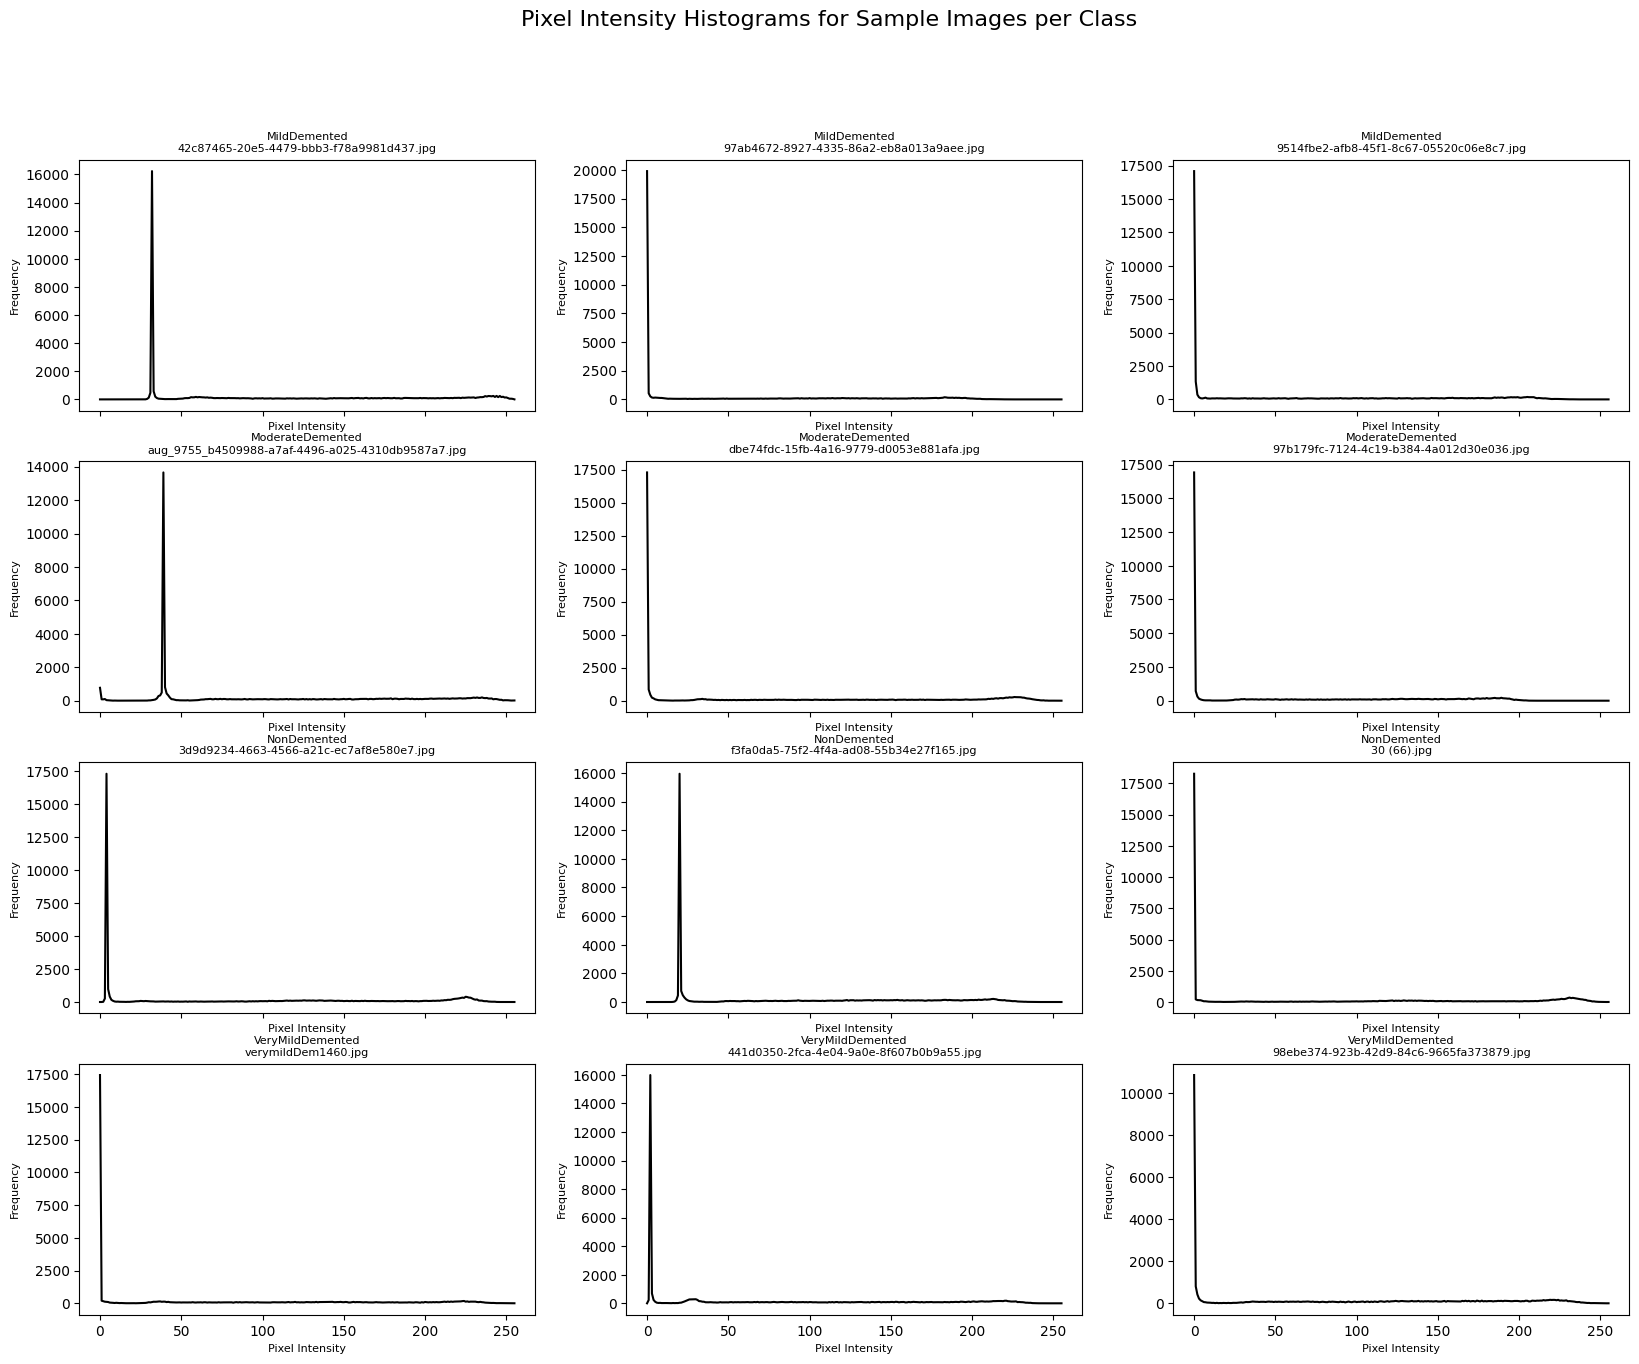

In [ ]:
import cv2

# 2. Define the base directory for the images
base_dir = './alzheimers_multiclass_dataset/combined_images'

# 3. Get a list of class names from the subdirectories
classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

# 4. Initialize a figure with subplots
num_samples_per_class = 3 # Number of sample images to display per class
fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(20, 15), sharex=True, sharey=False)
fig.suptitle('Pixel Intensity Histograms for Sample Images per Class', fontsize=16)

for i, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Select a few random sample image paths
    np.random.seed(42) # for reproducibility
    sample_image_names = np.random.choice(image_files, num_samples_per_class, replace=False)

    for j, image_name in enumerate(sample_image_names):
        image_path = os.path.join(class_path, image_name)

        # i. Load the image using cv2.imread()
        img = cv2.imread(image_path)

        # Check if image was loaded successfully
        if img is None:
            print(f"Warning: Could not load image {image_path}")
            continue

        # ii. Convert the image from BGR to grayscale using cv2.cvtColor()
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # iii. Calculate the histogram of pixel intensities using cv2.calcHist()
        # The histogram should have 256 bins, covering the range 0-255.
        hist = cv2.calcHist([gray_img], [0], None, [256], [0, 256])

        # iv. Plot the histogram on the appropriate subplot
        current_ax = axes[i, j]
        current_ax.plot(hist, color='black')
        current_ax.set_title(f'{class_name}\n{image_name}', fontsize=8)
        current_ax.set_xlabel('Pixel Intensity', fontsize=8)
        current_ax.set_ylabel('Frequency', fontsize=8)

In [ ]:
from scipy.stats import entropy

# Create an empty list to store dictionaries of features
features_list = []

# Define the number of samples to process per class to manage computational load
num_samples_to_process = 1000 # Using 1000 images per class for feature extraction

def extract_image_features(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image was loaded successfully
    if img is None:
        # print(f"Warning: Could not load image {image_path}") # Uncomment for debugging
        return None

    # Calculate mean pixel intensity
    mean_intensity = np.mean(img)

    # Calculate standard deviation of pixel intensity
    std_dev_intensity = np.std(img)

    # Calculate variance of pixel intensity
    variance_intensity = np.var(img)

    # Calculate Shannon entropy
    # Compute histogram (256 bins, range 0-255)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum() # Normalize to get probability distribution
    # Remove zero probabilities to avoid log(0) which results in inf values
    hist = hist[hist > 0]
    shannon_entropy = entropy(hist, base=2) # Calculate entropy with base 2

    return {
        'mean_intensity': mean_intensity,
        'std_dev_intensity': std_dev_intensity,
        'variance_intensity': variance_intensity,
        'shannon_entropy': shannon_entropy
    }

# Get a list of class names from the subdirectories
classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])

# Iterate through each class subdirectory
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Select a reasonable number of sample images (or all if less than num_samples_to_process)
    actual_samples = min(len(image_files), num_samples_to_process)
    selected_image_names = np.random.choice(image_files, actual_samples, replace=False)

    for image_name in selected_image_names:
        image_path = os.path.join(class_path, image_name)
        features = extract_image_features(image_path)

        if features is not None:
            features['class_name'] = class_name
            features['image_name'] = image_name
            features_list.append(features)

# Convert the features_list into a Pandas DataFrame
df_features = pd.DataFrame(features_list)

# Group by class_name and calculate the mean of all numerical features for each class
mean_features_by_class = df_features.groupby('class_name').mean(numeric_only=True)

# Print the mean_features_by_class DataFrame
print("Mean Image Features Grouped by Class:")
print(mean_features_by_class)


Mean Image Features Grouped by Class:
                  mean_intensity  std_dev_intensity  variance_intensity  \
class_name                                                                
MildDemented           71.502048          75.965256         5909.970617   
ModerateDemented       71.658753          76.454124         5992.056980   
NonDemented            79.392141          82.865578         6981.956150   
VeryMildDemented       74.262582          78.857226         6353.068693   

                  shannon_entropy  
class_name                         
MildDemented             5.152727  
ModerateDemented         5.171690  
NonDemented              5.221042  
VeryMildDemented         5.206638  


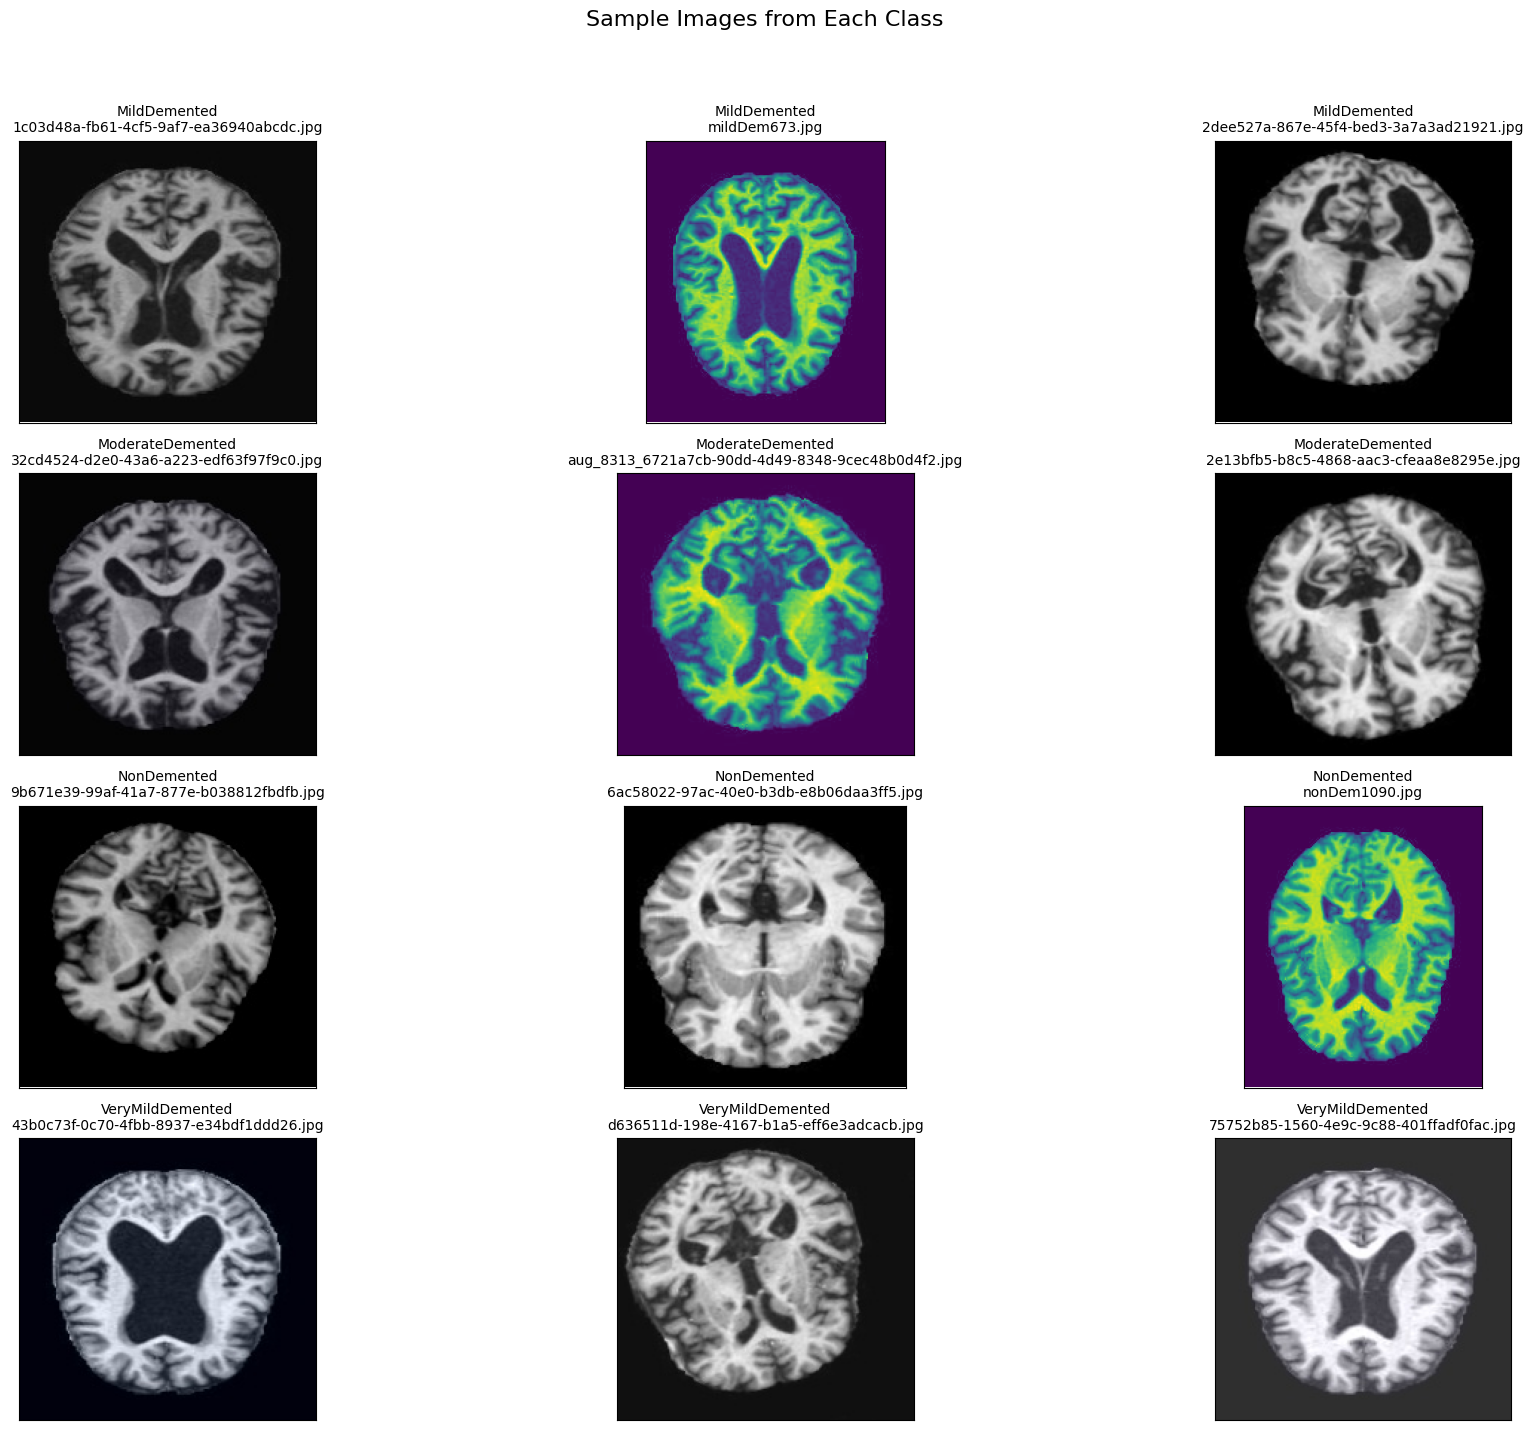

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt # Ensure plt is imported
import os # Ensure os is imported

# 2. Define the base directory for the images
base_dir = './alzheimers_multiclass_dataset/combined_images'

# 3. Create a figure and a set of subplots
num_samples_per_class = 3 # Number of sample images to display per class
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
classes.sort() # Ensure consistent order

fig, axes = plt.subplots(len(classes), num_samples_per_class, figsize=(20, 15)) # Increased figsize
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # 6. Select a few sample image paths from the list for the current class
    sample_images = image_files[:num_samples_per_class]

    for j, image_name in enumerate(sample_images):
        image_path = os.path.join(class_path, image_name)
        # 7. For each selected image, load it and display it in a subplot
        img = Image.open(image_path)
        # Using 'viridis' colormap for visual enhancement. 'gray' is also a common choice for MRI.
        axes[i, j].imshow(img, cmap='viridis')
        # 8. Set the title for each subplot to indicate the class and the image's original filename
        axes[i, j].set_title(f'{class_name}\n{image_name}', fontsize=10) # Increased fontsize
        # 9. Turn off the axis ticks for cleaner visualization
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

# 10. Adjust the layout to prevent titles from overlapping and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

## Implications of Data Augmentation

Based on the class distribution analysis and visual inspection of sample images, we can infer some implications regarding data augmentation:

1.  **Addressing Class Imbalance**: The class distribution shows that 'VeryMildDemented' and 'NonDemented' have significantly more images (11200 and 12800 respectively) compared to 'MildDemented' and 'ModerateDemented' (10000 each). Although the dataset is titled "equal and augmented," there's still a slight imbalance. Data augmentation techniques applied to the minority classes would have been crucial to achieve a more balanced dataset, which helps prevent a model from being biased towards the majority classes.

2.  **Increased Dataset Size**: The sheer number of images in each class (tens of thousands) strongly suggests that data augmentation has been applied extensively. Original MRI datasets for medical conditions like Alzheimer's are typically smaller. Augmentation (e.g., rotations, flips, shifts, zooms) artificially expands the training set, enhancing the model's ability to generalize by exposing it to a wider variety of image orientations and appearances.

3.  **Improved Model Robustness**: By introducing variations of existing images, augmentation makes the model more robust to minor distortions or differences in real-world input. This is particularly important in medical imaging where image acquisition can vary.

4.  **Potential for Artifacts**: While beneficial, excessive or inappropriate augmentation can sometimes introduce artifacts or unrealistic variations that might confuse the model. Visual inspection of sample images (as performed in the previous step) is important to ensure the augmented images still represent plausible data.

5.  **Reduced Overfitting**: A larger and more diverse dataset (due to augmentation) reduces the risk of overfitting, especially in deep learning models which have a high capacity to memorize training data.

In summary, data augmentation appears to have been used to balance and significantly expand the dataset, which is a standard and effective strategy for training robust image classification models, particularly in medical contexts where data collection can be challenging.